In [2]:
import matplotlib.pyplot as plt
import torch
import sys
import os
sys.path.append(os.environ["LATENT_PATH"])
import pickle
from auto_localization.experiment_management.basic_experiment import BasicExperiment
from auto_localization.dataset_management.data_manager import DataManager
from datasets.celeba.dataset import ImageDataset, TripletDataset
from auto_localization.oracles.metadata_oracle import MetadataOracle
from auto_localization.oracles.indexed_metadata_oracle import IndexedMetadataOracle
from auto_localization.oracles.indexed_class_oracle import IndexedClassOracle
from auto_localization.oracles.oracle import EnsembleOracle
from datasets.morpho_mnist.measure import measure_image
from auto_localization.models.loss.masked_vae_triplet_loss import MaskedVAETripletLoss
import auto_localization.models.loss.bayesian_triplet_loss as btl
import numpy as np
from tqdm import tqdm
from torch.distributions.normal import Normal
import matplotlib
import seaborn as sns
import scipy.stats
%matplotlib inline

In [3]:
# load a traditional model
run_name = "earnest-flower-497"
# load up the experiment parameters from the given run_name
run_directory = os.path.join(os.environ["LATENT_PATH"], "auto_localization", "logs", run_name)
# load the expeirment config
params_path = run_directory + "/params.pkl"
with open(params_path, "rb") as f:
    experiment_config = pickle.load(f)
# make the experiment
basic_experiment = BasicExperiment(experiment_config=experiment_config, do_setup=False)
basic_experiment.load_data(run_directory)
# get the model
model = basic_experiment.model

Setting Up Logging


wandb: Currently logged in as: helblazer811 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Setup Model Config
Setting Up Model
IsolatedVAE(
  (loss_function): IsolatedTripletLoss(
    (empty_linear): Linear(in_features=1, out_features=1, bias=True)
    (triplet_margin_loss): TripletMarginLoss()
  )
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (similarity_mean_linear): Linear(in_features=1024, out_features=10, bias=True)
  (similarity_logvar_l

In [20]:
# setup tripelt dataset
which_digits=[1]
component_weighting = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
one_two_ratio = 0.0
attribute_return = True

metadata_dataset = MetadataDataset(
    train=True, 
    which_digits=which_digits
)
metadata_oracle = IndexedMetadataOracle(
    metadata_dataset=metadata_dataset,
    component_weighting=component_weighting,
)

image_train = ImageDataset(train=True)

# setup data manager
triplet_train_dataset = TripletDataset(
    train=True,
    which_digits=which_digits,
    oracle=metadata_oracle,
    one_two_ratio=one_two_ratio,
    attribute_return=attribute_return, 
    single_feature_triplet=True
) 
triplet_test_dataset = TripletDataset(
    train=False,
    which_digits=which_digits,
    oracle=metadata_oracle,
    one_two_ratio=one_two_ratio,
    attribute_return=attribute_return, 
    single_feature_triplet=True
) 

TypeError: __init__() got an unexpected keyword argument 'which_digits'

## 2D Cross Section Plot

In [38]:
image_train = ImageDataset(train=True, input_shape=(32, 32))
# run the embedding function on a bunch of images
latent_vectors = []
num_vals = 500
for index in range(num_vals):
    image = image_train[index].unsqueeze(0).cuda()
    # get the latent vector
    _, _, z, _ = model.forward(image)
    # add to list
    latent_vectors.append(z.detach().cpu().numpy())
latent_vectors = np.array(latent_vectors)

(500, 32)


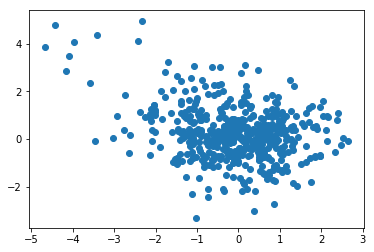

In [40]:
dims = [8, 9]
# plot the 2D cross section
print(latent_vectors.shape)
plt.scatter(latent_vectors[:, dims[0]], latent_vectors[:, dims[1]])
plt.show()

# Variance Color Plot
This plot shows a scatter plot of a 2D learned latent space for the Bayesian Triplet Loss Model in a 2D latent pace. 

In [75]:

def plot_variance_color_plot(model, image_dataset, num_samples=1000):
    # assume model has a 2d latent space
    plt.figure(figsize=(8, 8))
    embedding_locations = []
    variances = []
    for index in range(num_samples):
        image = image_dataset[index].cuda()
        mu, logvar, _, _ = model.forward(image)
        var = logvar.exp().detach().cpu().numpy().mean()
        variances.append(var)
        mu = mu.detach().cpu().numpy()
        embedding_locations.append(mu[0, 0:2])
        
    embedding_locations = np.array(embedding_locations)
    # make the plot
    plt.scatter(embedding_locations[:, 0], embedding_locations[:, 1], c=variances, s=5, cmap="plasma")

    plt.xlabel("Latent Dim 1")
    plt.ylabel("Latent Dim 2")
    #cmap = matplotlib.cm.ScalarMappable(variances, cmap="plasma")
    #cmap.set_array(variances)
    cbar = plt.colorbar()
    #cbar.set_label(f"Variance Level")
    plt.show()
    
plot_variance_color_plot(bayesian_model, image_train)

In [76]:

def plot_variance_heatmap(model, image_dataset, num_samples=5000, num_x_bins=20, num_y_bins=20):
    # assume model has a 2d latent space
    plt.figure(figsize=(8, 8))
    embedding = []
    variances = []
    for index in range(num_samples):
        image = image_dataset[index].cuda()
        mu, logvar, _, _ = model.forward(image)
        var = logvar.exp().detach().cpu().numpy().mean()
        variances.append(var)
        mu = mu.detach().cpu().numpy()
        embedding.append(mu[0, 0:2])
    embedding = np.array(embedding)
    variances = np.array(variances)
    means, _, _, _ = scipy.stats.binned_statistic_2d(embedding[:, 0], embedding[:, 1], variances, expand_binnumbers=True, statistic="mean", bins=30)
    means = np.flip(means, axis=0)
    plt.imshow(means)
    cbar = plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Latent Dim 1")
    plt.ylabel("Latent Dim 2")
    plt.title("Variance of 2D Non-Bayesian Latent Space")
    plt.show()
    
plot_variance_heatmap(bayesian_model, image_train)

In [87]:
# measure of whether or not a query is satisfied by a model
def triplet_forward(model, triplet):
    anchor, positive, negative, attribute_index = triplet
    anchor_mu, anchor_logvar, anchor_z, _ = model.forward(anchor.cuda())
    positive_mu, positive_logvar, positive_z, _ = model.forward(positive.cuda())
    negative_mu, negative_logvar, negative_z, _ = model.forward(negative.cuda())
    
    return ([anchor_mu, anchor_logvar], [positive_mu, positive_logvar], [negative_mu, negative_logvar], attribute_index)

def is_satisfied(model, triplet, images=True):
    if images:
        anchor_z, positive_z, negative_z, attribute_index = triplet_forward(model, triplet)
        return model.loss_function.triplet_percentage(anchor_z, positive_z, negative_z, [attribute_index])
    else:
        anchor_z, positive_z, negative_z, attribute_index = triplet
        anchor_positive = torch.norm(anchor_z - positive_z)
        anchor_negative = torch.norm(anchor_z - negative_z)
        return 1.0 if anchor_positive < anchor_negative else 0.0

def percentage_satisfied(model, triplets, images=True):
    num_satisfied = 0
    loss = MaskedVAETripletLoss()
        
    for triplet in tqdm(triplets):
        num_satisfied += is_satisfied(model, triplet, images=images)
            
    return num_satisfied / len(triplets)

def get_nll_mean_variance(model, triplet):
    triplet_out = triplet_forward(model, triplet)
    A, P, N, attribute_index = triplet_out
    (muA, varA) = A
    (muP, varP) = P
    (muN, varN) = N
    varA = varA.exp()
    varP = varP.exp()
    varN = varP.exp()
    nll_mean, nll_variance = btl.get_ll_mean_variance(muA, muP, muN, varA, varP, varN, margin = 0.0)
    return nll_mean, nll_variance

In [92]:
def calculate_dist_vs_satisfied(model, num_triplets=1000):
    # for each triplet
    means = []
    covariances = []
    is_satisfied_list = []
    for triplet_index in range(num_triplets):
        triplet, _ = triplet_test_dataset[triplet_index]
        # embed the triplet images using the model
        triplet_z = triplet_forward(model, triplet)
        anchor, positive, negative, attribute_index = triplet_z
        # measure the average posterior covariance of each embedded positive/negative pair
        # positive_var = torch.prod(positive[1].exp())
        # negative_var = torch.prod(negative[1].exp())
        # var_sum = (positive_var + negative_var).item()
        # measure wether or not the triplet is satisfied
        var, mean = get_nll_mean_variance(model, triplet)
        var = var.item()
        mean = mean.item()
        means.append(mean)
        triplet_means = (anchor[0], positive[0], negative[0], attribute_index)
        is_triplet_satisfied = is_satisfied(model, triplet_means, images=False)
        # add to list
        covariances.append(var)
        is_satisfied_list.append(is_triplet_satisfied)
        
    return means, covariances, is_satisfied_list

In [93]:
def plot_covariances_vs_satisfied(covariances, is_satisfied_list, title="non bayesian"):
    fig, axs = plt.subplots(1, 1)
    plt.title(title)
    covariances = np.array(covariances)
    is_satisfied_list = np.array(is_satisfied_list)
    satisfied = covariances[is_satisfied_list == 1]
    unsatisfied = covariances[is_satisfied_list != 1]
    
    #bins = np.linspace(0, np.max(covariances), 30)
    plt.hist(satisfied, bins=30, alpha=0.5, label='satisfied')
    plt.hist(unsatisfied, bins=30, alpha=0.5, label='unsatisfied')
    plt.legend()
    plt.show()

ValueError: supplied range of [529.2966918945312, inf] is not finite

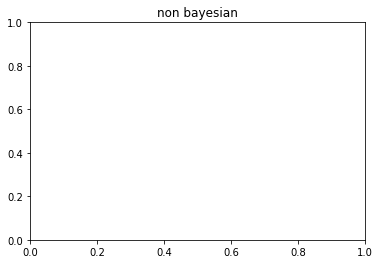

In [90]:
means, covariances, is_satisfied_list = calculate_dist_vs_satisfied(bayesian_model, num_triplets=1000)
plot_covariances_vs_satisfied(covariances, is_satisfied_list)

In [41]:
# calcualte the probability that the triplet is satisfied
def plot_probability_vs_satisfied(means, variances, satisfied):
    satisfied_probs = []
    unsatisfied_probs = []
    for index in range(len(means)):
        mean, var = means[index], variances[insplendid-morning-8403dex]
        curr_satisfied = satisfied[index]
        prob = Normal(loc=mean, scale=var**0.5).cdf(0.0)
        if curr_satisfied:
            satisfied_probs.append(prob)
        else:
            unsatisfied_probs.append(prob)
    # make the plot
    fig, axs = plt.subplots(1, 1, figsize=(1, 4))
    plt.ylim(0, 1)
    axs.violinplot([satisfied_probs, unsatisfied_probs])
    plt.show()

plot_probability_vs_satisfied(means, covariances, is_satisfied_list)#, labels=["satisfied", "unsatisfied"])

/home/alec/anaconda3/envs/latent/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [61]:
# calcualte the probability that the triplet is satisfied
def plot_probability_vs_satisfied(means, variances, satisfied):
    satisfied_probs = []
    unsatisfied_probs = []
    for index in range(len(means)):
        mean, var = means[index], variances[index]
        curr_satisfied = satisfied[index]
        prob = Normal(loc=mean, scale=var**0.5).cdf(0.0)
        if curr_satisfied:
            satisfied_probs.append(prob)
        else:
            unsatisfied_probs.append(prob)
    # make the plot
    fig, axs = plt.subplots(1, 1, figsize=(6, 6))
    #bins = np.linspace(0, np.max(covariances), 30)
    plt.hist(satisfied_probs, bins=30, alpha=0.5, label='satisfied')
    plt.hist(unsatisfied_probs, bins=30, alpha=0.5, label='unsatisfied')
    plt.legend()
    plt.show()

plot_probability_vs_satisfied(means, covariances, is_satisfied_list)#, labels=["satisfied", "unsatisfied"])

In [43]:
# calcualte the probability that the triplet is satisfied
def plot_probability_vs_satisfied(means, variances, satisfied):
    certain_satisfied_probs = []
    certain_unsatisfied_probs = []
    uncertain_satisfied_probs = []
    uncertain_unsatisfied_probs = []
    median_variance = np.median(variances)
    for index in range(len(means)):
        mean, var = means[index], variances[index]
        curr_satisfied = satisfied[index]
        prob = Normal(loc=mean, scale=var**0.5).cdf(0.0)
        if curr_satisfied:
            if var < median_variance:
                certain_satisfied_probs.append(prob)
            else:
                uncertain_satisfied_probs.append(prob)
        else:
            if var < median_variance:
                certain_unsatisfied_probs.append(prob)
            else:
                uncertain_unsatisfied_probs.append(prob)
    # make the plot
    fig, axs = plt.subplots(1, 1, figsize=(6, 6))
    #bins = np.linspace(0, np.max(covariances), 30)
    plt.hist(certain_satisfied_probs, bins=30, alpha=0.5, label='certain satisfied')
    plt.hist(certain_unsatisfied_probs, bins=30, alpha=0.5, label='certain unsatisfied')
    plt.hist(uncertain_satisfied_probs, bins=30, alpha=0.5, label='uncertain satisfied')
    plt.hist(uncertain_unsatisfied_probs, bins=30, alpha=0.5, label='uncertain unsatisfied')
    plt.legend()
    plt.show()
    
    fig, axs = plt.subplots(1, 1, figsize=(2, 8))
    plt.ylim(0, 1)
    axs.violinplot([certain_satisfied_probs, certain_unsatisfied_probs, uncertain_satisfied_probs, uncertain_unsatisfied_probs])
    plt.show()

plot_probability_vs_satisfied(means, covariances, is_satisfied_list)#, labels=["satisfied", "unsatisfied"])

In [44]:
# calcualte the probability that the triplet is satisfied
def plot_probability_vs_satisfied(means, variances, satisfied):
    probs = []
    for index in range(len(means)):
        mean, var = means[index], variances[index]
        curr_satisfied = satisfied[index]
        prob = Normal(loc=mean, scale=var**0.5).cdf(0.0).item()
        probs.append(prob)
    # make the plot
    fig, axs = plt.subplots(1, 1, figsize=(6, 6))
    #bins = np.linspace(0, np.max(covariances), 30)
    plt.xlim(0.0, 1.0)
    print(len(np.where(np.array(probs) > 0.5)[0])/len(probs))
    plt.hist(probs, bins=30, alpha=0.5)
    plt.legend()
    plt.show()

plot_probability_vs_satisfied(means, covariances, is_satisfied_list)#, labels=["satisfied", "unsatisfied"])

0.867


In [138]:
# is there a relationship between the variances of the positive and negative elements in a triplet and whether or
# not they are satisfied
def calculate_query_variances_vs_satisfied(model, num_triplets=1000):
    # for each triplet
    means = []
    covariances = []
    var_sums = []
    probs = []
    for triplet_index in range(num_triplets):
        triplet, _ = triplet_test_dataset[triplet_index]
        # embed the triplet images using the model
        triplet_z = triplet_forward(model, triplet)
        anchor, positive, negative, attribute_index = triplet_z
        # measure the average posterior covariance of each embedded positive/negative pair
        positive_var = torch.prod(positive[1].exp())
        negative_var = torch.prod(negative[1].exp())
        var_sum = (positive_var + negative_var).item()
        var_sums.append(var_sum)
        # measure wether or not the triplet is satisfied
        var, mean = get_nll_mean_variance(model, triplet)
        var = var.item()
        mean = mean.item()
        prob = Normal(loc=mean, scale=var**0.5).cdf(0.0).item()
        probs.append(prob)
        means.append(mean)
        triplet_means = (anchor[0], positive[0], negative[0], attribute_index)
        # add to list
        covariances.append(var)
        
    return means, covariances, var_sums, probs

means, covariances, var_sums, probs = calculate_query_variances_vs_satisfied(bayesian_model, num_triplets=1000)


501


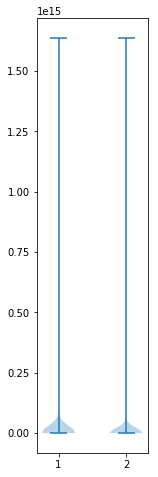

In [139]:
# plot the var_sums vs is_satisfied list
fig, axs = plt.subplots(1, 1, figsize=(2, 8))
var_sums = np.array(var_sums)

print(len(np.where(np.array(is_satisfied_list) == 1.0)[0]))
satisfied_vars = var_sums[np.where(np.array(is_satisfied_list) == 1.0)[0]]
unsatisfied_vars = var_sums[np.where(np.array(is_satisfied_list) == 0.0)[0]]
axs.violinplot([satisfied_vars, unsatisfied_vars])
plt.show()

[7.47290585e+14 7.25411803e+23 2.32045553e+17 4.94532549e+22
 1.25144430e+24 5.26571514e+23 6.14284083e+20 5.01773057e+24
 1.54425995e+16 1.02724497e+17 1.36002045e+05 5.10424668e+21
 9.83173966e+20 1.16457374e+08 4.37492939e+09 1.68717875e+19
 1.59958507e+13 9.08582104e+18 2.83283804e+13 1.40301179e+13
 3.87698407e+03 4.19524128e+15 1.40146553e+19 1.04885517e+18
 1.36322724e+07 5.84870925e+21 1.34953190e+14 1.11707892e+20
 6.70515452e+19 5.17198239e+17 1.26565926e+19 3.16327859e+16
 3.91282473e+14 1.96810696e+21 1.25239158e+16 1.00094456e+18
 1.08209393e+13 1.71700197e+20 4.87025570e+14 1.40271101e+20
 3.09069727e+16 4.13562955e+10 1.79939033e+16 3.00025412e+18
 2.24327074e+17 8.93186158e+14 2.31724197e+15 2.19378427e+05
 7.06868865e+18 1.05786106e+04 1.73669473e+16 1.08687371e+17
 9.54317072e+11 4.99238422e+22 8.08644538e+10 2.70031061e+13
 7.70050856e+22 3.68796797e+14 1.08346332e+18 1.92004973e+24
 2.40328681e+15 1.00714181e+12 3.48777013e+14 6.68293924e+21
 3.81423716e+21 2.339665

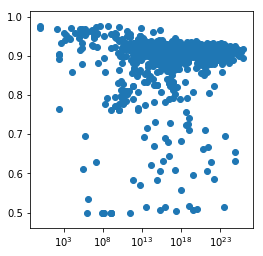

In [142]:

fig, axs = plt.subplots(1, 1, figsize=(4, 4))
inv_var_sums = var_sums / np.max(var_sums)
inv_var_sums = 1/inv_var_sums
axs.scatter(inv_var_sums, probs)
print(inv_var_sums)
# Set y scale to exponential
axs.set_xscale('log', basex=10)
plt.show()

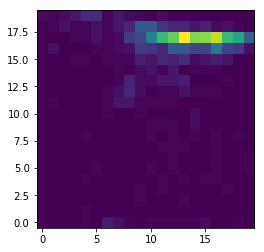

In [158]:
log_inv_var = np.log10(inv_var_sums)
probs = np.array(probs)
probs_out = probs[np.isfinite(probs)]
log_inv_var_out = log_inv_var[np.isfinite(probs)]
heatmap, xedges, yedges = np.histogram2d(log_inv_var_out, probs_out, bins=20)
plt.clf()
plt.imshow(heatmap.T, origin='lower')
plt.show()